<a href="https://colab.research.google.com/github/AksaRose/Reinforcement_learning/blob/main/Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from collections import defaultdict
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import os


class BlackjackAgent:
  def __init__(
      self,
      env:gym.Env,
      learning_rate: float,
      initial_epsilon: float,
      epsilon_decay: float,
      final_epsilon: float,
      discount_factor: float =0.99

  ):
    self.env = env
    self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
    self.learning_rate = learning_rate
    self.epsilon = initial_epsilon
    self.epsilon_decay = epsilon_decay
    self.final_epsilon = final_epsilon
    self.discount_factor = discount_factor

    self.training_error = []

  def get_action(self,obs:tuple[int,int,bool])->int:
    if (np.random.random() < self.epsilon):
      return self.env.action_space.sample()
    else:
      return int(np.argmax(self.q_values[obs]))


  def update(self,obs: tuple[int,int,bool],action:int,terminated:bool,reward:float,next_obs:tuple[int,int,bool]):
    future_q_value = (not terminated) * np.max(self.q_values[next_obs])
    target = reward + self.discount_factor * future_q_value

    tempory_error = target - self.q_values[obs][action]

    self.q_values[obs][action] = (self.q_values[obs][action] + self.learning_rate * tempory_error)

    self.training_error.append(tempory_error)
  def decay_epsilon(self):
    self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


In [61]:
learning_rate = 0.02
n_episodes = 700_000
start_epsilon = 1.0
epsilon_decay = 0.999995
final_epsilon = 0.1

# Clean any previous recordings
if os.path.exists("videos"):
    !rm -rf videos

env = gym.make("Blackjack-v1", sab=False, render_mode="rgb_array")
env = RecordVideo(env, video_folder="videos", episode_trigger=lambda e: e % 10000 == 0)
env = RecordEpisodeStatistics(env, buffer_length=n_episodes)


agent = BlackjackAgent(
    env = env,
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon

)


In [62]:
from tqdm import tqdm

for epsisode in tqdm(range(n_episodes)):
  obs,info = env.reset()
  done = False
  while not done:
    action = agent.get_action(obs)
    next_obs,reward,terminated,truncated, info = env.step(action)

    agent.update(obs,action,terminated,reward,next_obs)
    done = terminated or truncated
    obs = next_obs
  agent.decay_epsilon()


100%|██████████| 700000/700000 [01:50<00:00, 6306.84it/s]


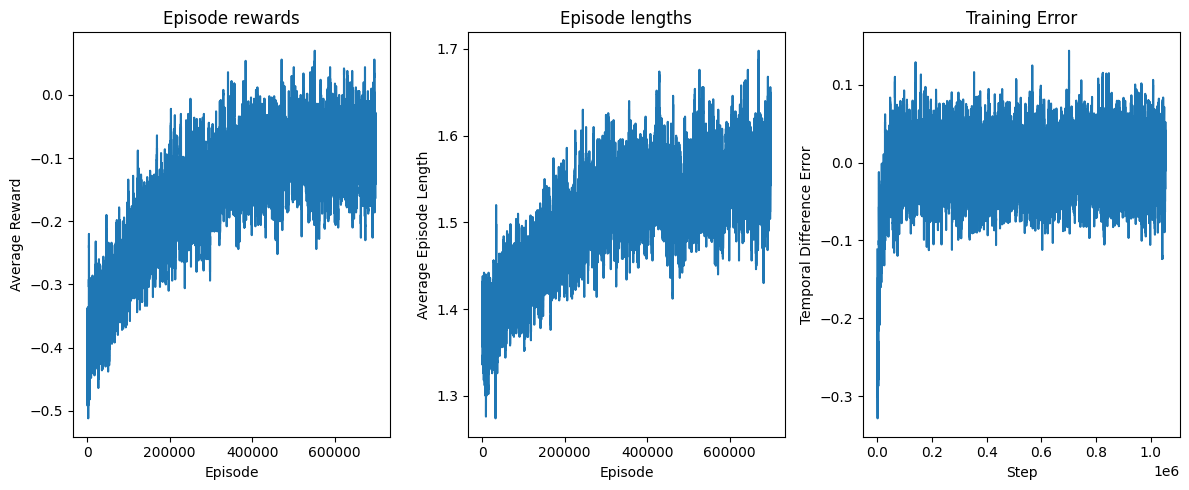

In [63]:
from matplotlib import pyplot as plt


def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [54]:
from IPython.display import Video

# Display the recorded video
Video("./videos/rl-video-episode-0.mp4", embed=True)